In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from scipy.spatial.distance import hamming

# 1. Подготовка данных
# Загрузка датасета Iris
iris = datasets.load_iris()
data = iris.data
target = iris.target

# Нормализация признаков
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Дискретизация и бинаризация данных
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform', subsample=None)
discretized_data = binner.fit_transform(normalized_data)
binary_data = np.where(discretized_data > discretized_data.mean(), 1, -1)


In [2]:
# 2. Моделирование сети
# Определение сети Хопфилда
class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train(self, patterns):
        for pattern in patterns:
            pattern = pattern.reshape(-1, 1)
            self.weights += pattern @ pattern.T
        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)

    def recall(self, pattern, steps=10):
        pattern = pattern.copy()
        for _ in range(steps):
            pattern = np.sign(self.weights @ pattern)
        return pattern
        

In [3]:
# 3. Обучение
# Обучение сети Хопфилда
hopfield = HopfieldNetwork(size=binary_data.shape[1])
hopfield.train(binary_data)

# Восстановление образцов с помощью сети Хопфилда
recalled_patterns = np.array([hopfield.recall(pattern.reshape(-1, 1)).flatten() 
                              for pattern in binary_data])

# Расчет метрики силуэта
hamming_distances = np.array([[hamming(p1, p2) for p2 in recalled_patterns] 
                              for p1 in recalled_patterns])
hopfield_silhouette = silhouette_score(hamming_distances, target, metric='precomputed')


In [4]:
# 4. Анализ
# Анализ группировки сети Хопфилда
unique_patterns, counts = np.unique(recalled_patterns, axis=0, return_counts=True)

# Сравнение восстановленных кластеров с реальными классами
hopfield_labels = np.array([np.argmin([np.sum(p != pattern) for p in unique_patterns]) 
                            for pattern in recalled_patterns])
hopfield_accuracy = accuracy_score(target, hopfield_labels)
hopfield_confusion = confusion_matrix(target, hopfield_labels)


Точность сети Хопфилда: 0.6733
Матрица ошибок сети Хопфилда:
 [[50  0  0]
 [ 0  1 49]
 [ 0  0 50]]

Точность K-Means: 0.4533
Матрица ошибок K-Means:
 [[50  0  0]
 [ 0 10 40]
 [ 0 42  8]]

Уникальные кластеры, найденные сетью Хопфилда: 3
Метрика силуэта для сети Хопфилда: 0.3400
Метрика силуэта для K-Means: 0.4829



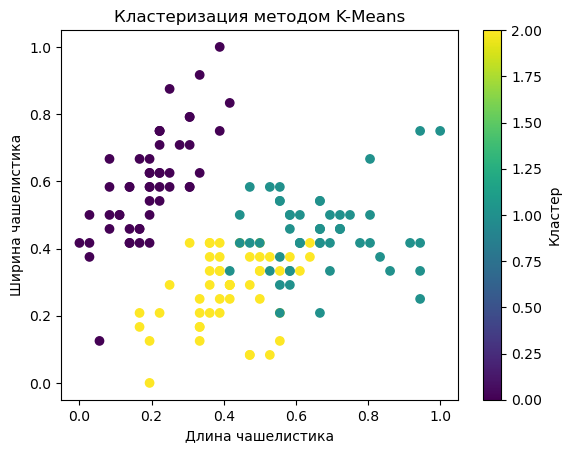

In [5]:
# 5. Сравнение 
# Сравнение с методом K-Means
kmeans = KMeans(n_clusters=3, random_state=22)
kmeans_labels = kmeans.fit_predict(normalized_data)
kmeans_silhouette = silhouette_score(normalized_data, kmeans_labels)
kmeans_accuracy = accuracy_score(target, kmeans_labels)
kmeans_confusion = confusion_matrix(target, kmeans_labels)

# Результаты
print(f"Точность сети Хопфилда: {hopfield_accuracy:.4f}")
print(f"Матрица ошибок сети Хопфилда:\n {hopfield_confusion}")

print(f"\nТочность K-Means: {kmeans_accuracy:.4f}")
print(f"Матрица ошибок K-Means:\n {kmeans_confusion}")

print(f"\nУникальные кластеры, найденные сетью Хопфилда: {len(unique_patterns)}")
print(f"Метрика силуэта для сети Хопфилда: {hopfield_silhouette:.4f}")
print(f"Метрика силуэта для K-Means: {kmeans_silhouette:.4f}\n")

# Визуализация результатов K-Means
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("Кластеризация методом K-Means")
plt.xlabel("Длина чашелистика")
plt.ylabel("Ширина чашелистика")
plt.colorbar(label="Кластер")
plt.show()
